In [1]:
import sys, os, json
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import nltk
from scipy import spatial
from scipy.stats import pearsonr
from collections import *

In [2]:
AnnoteTable = pd.read_csv('../data/AnnotationTable.csv')

In [3]:
tmp_d = defaultdict(list)
for _, row in AnnoteTable.iterrows():
    if row['12'] == row['12']:
        tmp_d[row.Response].append(row['12'])
response_to_avgannote12 = {k: np.mean(v) for k, v in tmp_d.items()}

In [4]:
AnnoteTableSmaller = AnnoteTable[['Session', 'Form', 'Item', 'WCPM_response', 'Response']].copy(deep=True).drop_duplicates()

In [5]:
get_avgannote12 = lambda x: response_to_avgannote12[x] if x in response_to_avgannote12 else np.nan

AnnoteTableSmaller['AvgAnnote12'] = AnnoteTableSmaller.Response.apply(get_avgannote12)

In [6]:
AnnoteTableSmaller = AnnoteTableSmaller.dropna()

In [7]:
AnnoteTableSmaller.to_csv('AnnoteTable12.csv', index=None)

In [7]:
SENTENCE_CORRECTNESS_THRESHOLD = 1/3
TOKEN_CORRECTNESS_THRESHOLD = 0.8

In [8]:
with open('../data/moby/jsons/item_to_passage_new.json') as f:
    item_to_passage = json.load(f)

In [9]:
form_to_items = defaultdict(list)
with open('../data/moby/jsons/item_to_form.json') as f:
    item_to_form = json.load(f)
for item, form in item_to_form.items():
    form_to_items[form].append(item)

In [10]:
item_to_sent_indices = {}
for item, passage in item_to_passage.items():
    sents = nltk.sent_tokenize(passage)
    
    sent_indices = []
    sent_begin_idx = 0
    for sent in sents:
        n_tokens = len(sent.split())
        sent_indices.append(list(range(sent_begin_idx, sent_begin_idx + n_tokens)))
        sent_begin_idx += n_tokens
    item_to_sent_indices[item] = sent_indices
    
    assert len(item_to_passage[item].split()) - 1 == sent_indices[-1][-1]


In [11]:
def sent_indices_to_perfmat_indices(indices, mode):
#     mode = 'tokens', 'pauses', 'both'
    if mode == 'tokens':
        return (2 * np.array(indices)) + 1
    if mode == 'pauses':
        return (2 * np.array(indices)) + 2
    if mode == 'both':
        return np.arange(2 * indices[0] + 1, 2 * indices[-1] + 3)
    assert False, 'invalid mode'

In [12]:
PERFMAT_ROOT = '../output/performance-matrix/all-fixed'

test_item = '330'
test_response_path = os.path.join(PERFMAT_ROOT, '330-184/30915.tsv')
test_gold_dfs = []
for df_path in os.listdir(os.path.join(PERFMAT_ROOT, test_item + '-182')):
    if df_path.endswith('tsv'):
        test_gold_dfs.append(pd.read_csv(os.path.join(PERFMAT_ROOT, test_item + '-182', df_path), sep='\t'))

test_response_df = pd.read_csv(test_response_path, sep='\t')

def compute_sentence_correct_proportion(item, response_df, token_correctness_threshold=0.5):
    correct_sentence_flags = []
    for sent in item_to_sent_indices[item]:
        perfmat_token_indices = sent_indices_to_perfmat_indices(sent, mode='tokens')
        correct_token_flags = [response_df.matches_expected[idx] for idx in perfmat_token_indices]
        correct_sentence_flags.append(bool(np.mean(correct_token_flags) >= token_correctness_threshold))
    good_sentence_indices = [i for i, flag in enumerate(correct_sentence_flags) if flag]
    return np.mean(correct_sentence_flags), good_sentence_indices
        
def feature_template(item, response_path, gold_dfs):
    response_df = pd.read_csv(response_path, sep='\t')
    
    sentence_correct_proportion, good_sentence_indices = compute_sentence_correct_proportion(item, response_df)
    if sentence_correct_proportion < 0.5:
        return None

def get_lengths_from_indices(indices, df):
    return [df.nframes[idx] for idx in indices]

def cosine(v1, v2):
    return 1 - spatial.distance.cosine(v1, v2)

In [13]:
def avgannote12_to_color(val):
    if val == 3.0:
        return 'green'
    if val <= 2.0:
        return 'red'
    return 'gold'

In [14]:
def compute_basic_cosine_sim(item, response_path, gold_dfs, mode, drop_incorrect_tokens=False):
    response_df = pd.read_csv(response_path, sep='\t')
    sentence_correct_proportion, good_sentence_indices = compute_sentence_correct_proportion(
        item,
        response_df,
        token_correctness_threshold=TOKEN_CORRECTNESS_THRESHOLD
    )
    if sentence_correct_proportion < SENTENCE_CORRECTNESS_THRESHOLD:
        return None
    
    best_cosine_sims = []
    for good_sent_idx in good_sentence_indices:
        sent_indices = item_to_sent_indices[item][good_sent_idx]
        perfmat_indices = sent_indices_to_perfmat_indices(sent_indices, mode=mode)
        if drop_incorrect_tokens:
            perfmat_indices = [
                idx for idx in perfmat_indices
                if (idx % 2 != 0) or (response_df.matches_expected[idx] == 1)
            ]
        response_lengths = get_lengths_from_indices(perfmat_indices, response_df)
        
        cosine_sims = []
        for gold_df in gold_dfs:
            gold_lengths = get_lengths_from_indices(perfmat_indices, gold_df)
#             print(response_lengths, gold_lengths)
            sim = cosine(response_lengths, gold_lengths)
            cosine_sims.append(sim)
        
        best_cosine_sims.append(max(cosine_sims))
    return np.mean(best_cosine_sims)

log: Grade1Fall
log: Grade1Winter
log: Grade1Spring
log: Grade2Fall
log: Grade2Winter
log: Grade2Spring
log: Grade3Fall
log: Grade3Winter
log: Grade3Spring
log: Grade4Fall
log: Grade4Winter
log: Grade4Spring


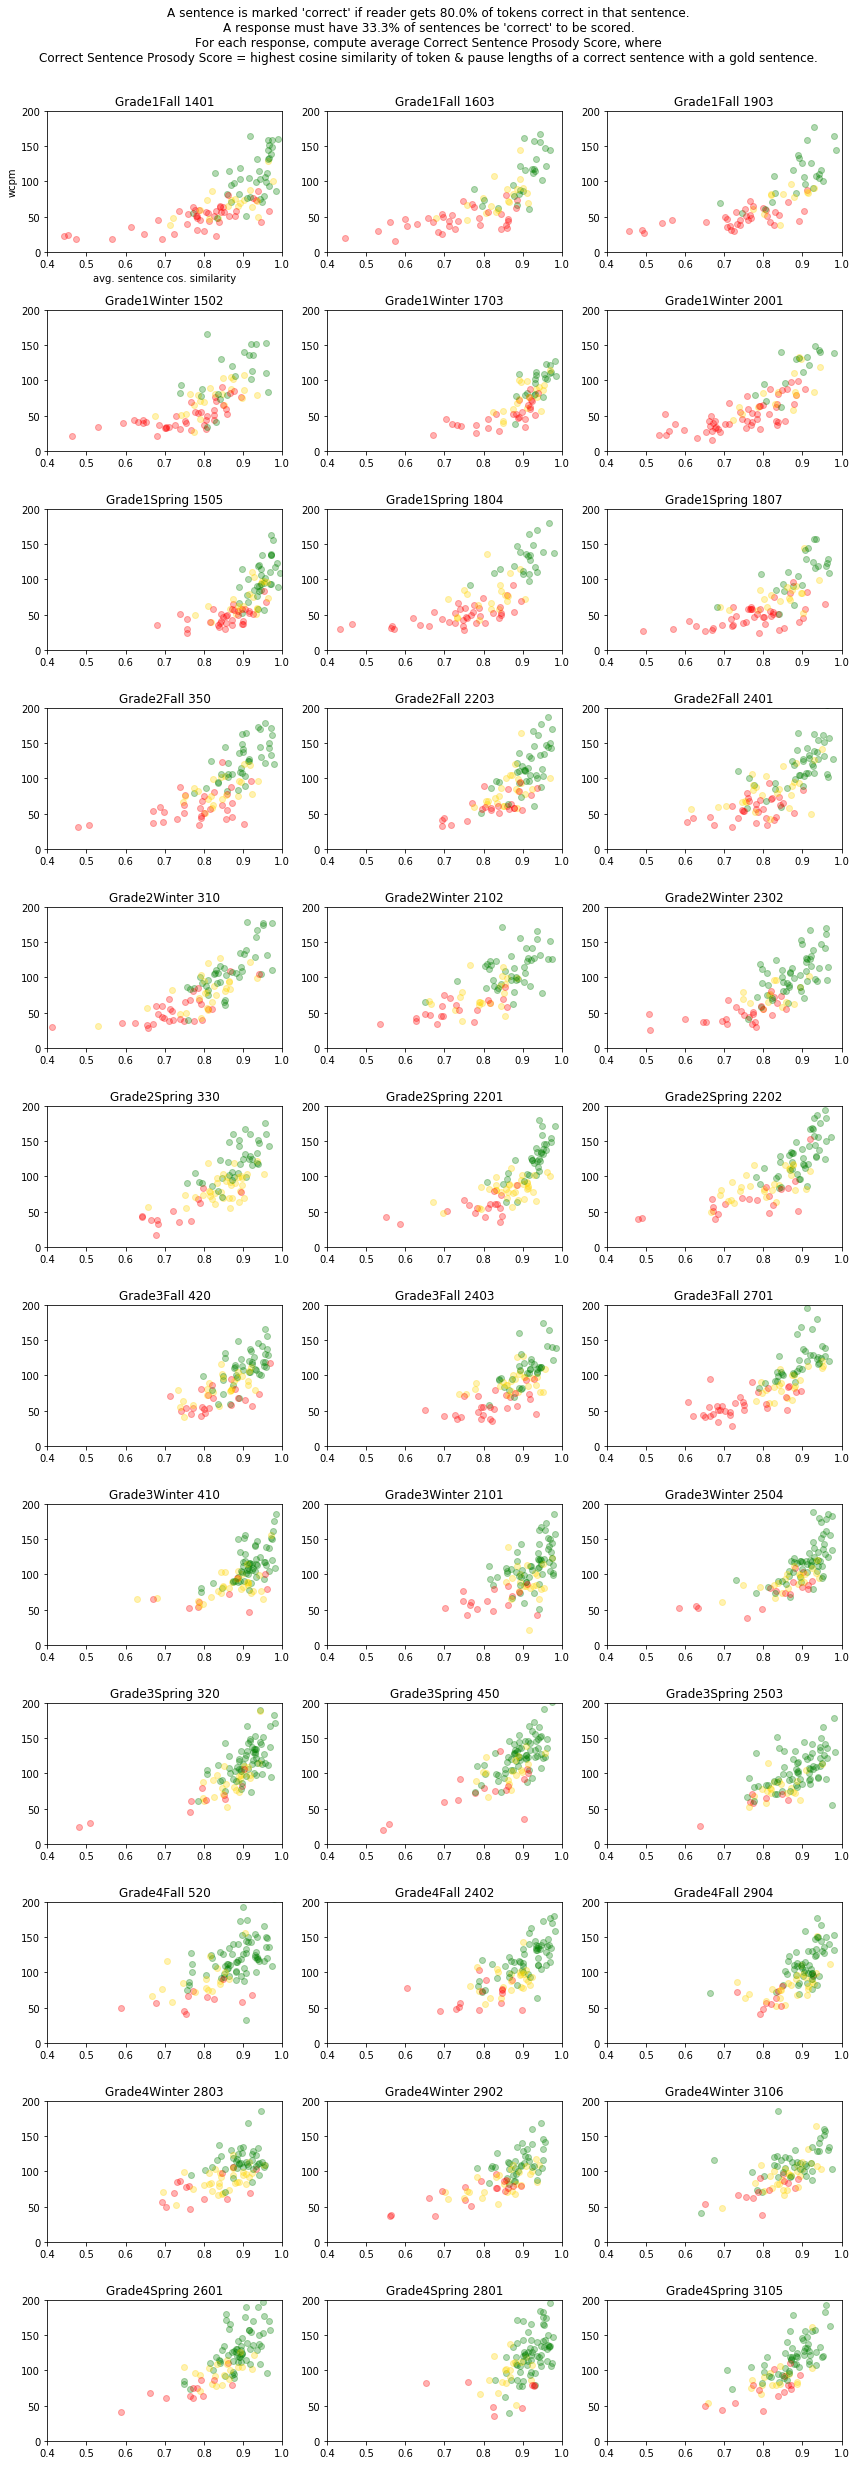

In [15]:
fig, axs = plt.subplots(12, 3)
fig.set_figwidth(12)
fig.set_figheight(36)

title_string = '''A sentence is marked 'correct' if reader gets {:.1f}% of tokens correct in that sentence.
A response must have {:.1f}% of sentences be 'correct' to be scored.
For each response, compute average Correct Sentence Prosody Score, where
Correct Sentence Prosody Score = highest cosine similarity of token & pause lengths of a correct sentence with a gold sentence.
'''.format(100 * TOKEN_CORRECTNESS_THRESHOLD, 100 * SENTENCE_CORRECTNESS_THRESHOLD)

fig.suptitle(title_string)

axs[0, 0].set_xlabel('avg. sentence cos. similarity')
axs[0, 0].set_ylabel('wcpm')

item_to_xy_pairs = defaultdict(list)
item_to_total_responses = defaultdict(int)
item_to_kept_responses = defaultdict(int)
x_vals_list = []

for grade_idx, grade in enumerate(('Grade1', 'Grade2', 'Grade3', 'Grade4')):
    for term_idx, term in enumerate(('Fall', 'Winter', 'Spring')):
        form = grade + term
        print('log:', form)
        
        for item in form_to_items[form]:
            
            subplot_x = 3 * grade_idx + term_idx
            subplot_y = form_to_items[form].index(item)
            
            axs[subplot_x, subplot_y].set_title(' '.join((form, item)))
            axs[subplot_x, subplot_y].set_xlim(0.4, 1)
            axs[subplot_x, subplot_y].set_ylim(0, 200)
            
            AnnoteTable_item = AnnoteTableSmaller.loc[AnnoteTable.Item == int(item)]
            gold_dfs = []
            for df_path in os.listdir(os.path.join(PERFMAT_ROOT, item + '-182')):
                if df_path.endswith('tsv'):
                    gold_dfs.append(pd.read_csv(os.path.join(PERFMAT_ROOT, item + '-182', df_path), sep='\t'))
            
#             DEBUG_CT = 0
            
            for child_df_path in os.listdir(os.path.join(PERFMAT_ROOT, item + '-184')):
                if not child_df_path.endswith('tsv'):
                    continue
                
#                 if DEBUG_CT >= 10:
#                     break
#                 DEBUG_CT += 1
                    
                session = child_df_path.replace('.tsv', '')
#                 child_df = pd.read_csv(, sep='\t')
                
                response_row = AnnoteTable_item.loc[AnnoteTable_item.Session == int(session)]
                if len(response_row) != 1:
                    continue
                avgannote12 = float(response_row.AvgAnnote12)
                response_wcpm = float(response_row.WCPM_response)
                
                cosine_sim = compute_basic_cosine_sim(
                    item, 
                    os.path.join(PERFMAT_ROOT, item + '-184', child_df_path),
                    gold_dfs,
                    mode='both',
                    drop_incorrect_tokens=True
                )
                
                item_to_total_responses[form + ' ' + item] += 1
                if cosine_sim == None:
                    continue
                item_to_kept_responses[form + ' ' + item] += 1
                
                x_vals_list.append(cosine_sim)
                
#                 PLOT
                plot_color = avgannote12_to_color(avgannote12)
                
                axs[subplot_x, subplot_y].scatter(
                    cosine_sim,
                    response_wcpm,
                    color=plot_color,
                    alpha=0.3
                )
                item_to_xy_pairs[form + ' ' + item].append((cosine_sim, response_wcpm))
            
#             break # break item
#         break # break term
#     break # break grade

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('1216-scatter.png')

(array([  2.,   0.,   2.,   6.,   8.,   8.,  15.,  12.,  22.,  43.,  81.,
         87., 152., 240., 309., 434., 580., 579., 475., 160.]),
 array([0.33720347, 0.37004419, 0.40288491, 0.43572563, 0.46856634,
        0.50140706, 0.53424778, 0.5670885 , 0.59992922, 0.63276994,
        0.66561066, 0.69845138, 0.73129209, 0.76413281, 0.79697353,
        0.82981425, 0.86265497, 0.89549569, 0.92833641, 0.96117713,
        0.99401784]),
 <a list of 20 Patch objects>)

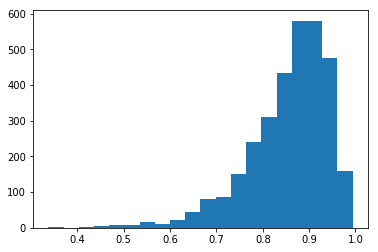

In [16]:
plt.hist(x_vals_list, bins=20)

In [17]:
for item, n_total_responses in item_to_total_responses.items():
    print('{:20s} {:.1f}'.format(item, 100 * item_to_kept_responses[item] / n_total_responses))

Grade1Fall 1401      97.1
Grade1Fall 1603      83.9
Grade1Fall 1903      69.0
Grade1Winter 1502    93.4
Grade1Winter 1703    78.2
Grade1Winter 2001    92.2
Grade1Spring 1505    90.0
Grade1Spring 1804    79.8
Grade1Spring 1807    83.8
Grade2Fall 350       91.0
Grade2Fall 2203      85.1
Grade2Fall 2401      97.0
Grade2Winter 310     94.1
Grade2Winter 2102    83.3
Grade2Winter 2302    90.1
Grade2Spring 330     94.5
Grade2Spring 2201    92.7
Grade2Spring 2202    97.9
Grade3Fall 420       91.9
Grade3Fall 2403      92.8
Grade3Fall 2701      92.9
Grade3Winter 410     99.0
Grade3Winter 2101    98.0
Grade3Winter 2504    96.0
Grade3Spring 320     100.0
Grade3Spring 450     99.0
Grade3Spring 2503    96.9
Grade4Fall 520       97.0
Grade4Fall 2402      96.9
Grade4Fall 2904      92.9
Grade4Winter 2803    94.6
Grade4Winter 2902    92.4
Grade4Winter 3106    91.3
Grade4Spring 2601    95.0
Grade4Spring 2801    94.9
Grade4Spring 3105    90.6


In [18]:
for item, pairs in item_to_xy_pairs.items():
    v1, v2 = zip(*pairs)
    r = pearsonr(v1, v2)[0]
    print('{:20s} r={:.3f}'.format(item, r))

Grade1Fall 1401      r=0.699
Grade1Fall 1603      r=0.728
Grade1Fall 1903      r=0.727
Grade1Winter 1502    r=0.694
Grade1Winter 1703    r=0.756
Grade1Winter 2001    r=0.788
Grade1Spring 1505    r=0.714
Grade1Spring 1804    r=0.736
Grade1Spring 1807    r=0.699
Grade2Fall 350       r=0.710
Grade2Fall 2203      r=0.734
Grade2Fall 2401      r=0.734
Grade2Winter 310     r=0.788
Grade2Winter 2102    r=0.700
Grade2Winter 2302    r=0.727
Grade2Spring 330     r=0.762
Grade2Spring 2201    r=0.738
Grade2Spring 2202    r=0.767
Grade3Fall 420       r=0.712
Grade3Fall 2403      r=0.691
Grade3Fall 2701      r=0.779
Grade3Winter 410     r=0.613
Grade3Winter 2101    r=0.562
Grade3Winter 2504    r=0.688
Grade3Spring 320     r=0.696
Grade3Spring 450     r=0.714
Grade3Spring 2503    r=0.630
Grade4Fall 520       r=0.620
Grade4Fall 2402      r=0.694
Grade4Fall 2904      r=0.653
Grade4Winter 2803    r=0.591
Grade4Winter 2902    r=0.721
Grade4Winter 3106    r=0.635
Grade4Spring 2601    r=0.711
Grade4Spring 2